### Detect Duplicate Images via LSH


In [2]:
from PIL import Image
import os
import shutil
import glob2
import random
import uuid
from os import listdir
from os.path import isfile, join
import imagehash
from typing import Dict, List, Tuple
import imagehash
import numpy as np

### Rename the images and create duplicates with variations of resizing

In [3]:
def parse_images( input_folder: str, output_folder: str, csv_file: str ):
    """
    Rename the images and create duplicates with variations of resizing
    """
    if os.path.exists( output_folder ):
        try:
            shutil.rmtree( output_folder )
            os.remove( csv_file )
        except:
            pass

    # open the output file for writing
    output = open(csv_file, "w")
    os.mkdir( output_folder )

    # loop over the input images
    for imagePath in glob2.iglob(input_folder + "/*/*.jpg"):
        # generate a random filename for the image and copy it to
        # the output location
        filename = str(uuid.uuid4()) + ".jpg"
        shutil.copy(imagePath, output_folder + "/" + filename)

        # there is a 1 in 500 chance that multiple copies of this
        # image will be used
        if random.randint(0, 500) == 0:
            # initialize the number of times the image is being
            # duplicated and write it to the output CSV file
            numTimes = random.randint(1, 8)
            output.write("%s,%d\n" % (filename, numTimes))

            # loop over a random number of times for this image to
            # be duplicated
            for i in range(0, numTimes):
                image = Image.open(imagePath)

                # randomly resize the image, perserving aspect ratio
                factor = random.uniform(0.95, 1.05)
                width = int(image.size[0] * factor)
                ratio = width / float(image.size[0])
                height = int(image.size[1] * ratio)
                image = image.resize((width, height), Image.ANTIALIAS)

                # generate a random filename for the image and copy
                # it to the output directory
                adjFilename = str(uuid.uuid4()) + ".jpg"
                shutil.copy(imagePath, output_folder + "/" + adjFilename)

    # close the output file
    output.close()

parse_images( '../101_ObjectCategories/', './images', 'duplicates.csv')

In [4]:
def calculate_signature(image_file: str, hash_size: int) -> np.ndarray:
    """ 
    Calculate the dhash signature of a given file
    """
    pil_image = Image.open(image_file).convert("L").resize(
                        (hash_size+1, hash_size),
                        Image.ANTIALIAS)
    dhash = imagehash.dhash(pil_image, hash_size)
    signature = dhash.hash.flatten()
    pil_image.close()
    return signature


In [5]:
def find_near_duplicates(input_dir: str, threshold: float, hash_size: int, bands: int) -> List[Tuple[str, str, float]]:
    """
    Find near-duplicate images
    """
    rows: int = int(hash_size**2/bands)
    signatures = dict()
    hash_buckets_list: List[Dict[str, List[str]]] = [dict() for _ in range(bands)]
    
    # Build a list of candidate files in given input_dir
    file_list = [join(input_dir, f) for f in listdir(input_dir) if isfile(join(input_dir, f))]

    # Iterate through all files in input directory
    for fh in file_list:
        try:
            signature = calculate_signature(fh, hash_size)
        except IOError:
            # Not a PIL image, skip this file
            continue

        # Keep track of each image's signature
        signatures[fh] = np.packbits(signature)
        
        # Locality Sensitive Hashing
        for i in range(bands):
            signature_band = signature[i*rows:(i+1)*rows]
            signature_band_bytes = signature_band.tobytes()
            if signature_band_bytes not in hash_buckets_list[i]:
                hash_buckets_list[i][signature_band_bytes] = list()
            hash_buckets_list[i][signature_band_bytes].append(fh)

    # Build candidate pairs based on bucket membership
    candidate_pairs = set()
    for hash_buckets in hash_buckets_list:
        for hash_bucket in hash_buckets.values():
            if len(hash_bucket) > 1:
                hash_bucket = sorted(hash_bucket)
                for i in range(len(hash_bucket)):
                    for j in range(i+1, len(hash_bucket)):
                        candidate_pairs.add(
                            tuple([hash_bucket[i],hash_bucket[j]])
                        )

    # Check candidate pairs for similarity
    near_duplicates = list()
    for cpa, cpb in candidate_pairs:
        hd = sum(np.bitwise_xor(
                np.unpackbits(signatures[cpa]), 
                np.unpackbits(signatures[cpb])
        ))
        similarity = (hash_size**2 - hd) / hash_size**2
        if similarity > threshold:
            near_duplicates.append((cpa, cpb, similarity))
            
    # Sort near-duplicates by descending similarity and return
    near_duplicates.sort(key=lambda x:x[2], reverse=True)
    return near_duplicates


In [6]:
input_dir = './images'
threshold = 0.9
hash_size = 16
bands = 16

try:
    near_duplicates = find_near_duplicates(input_dir, threshold, hash_size, bands)
    if near_duplicates:
        print( f"Found {len(near_duplicates)} near-duplicate images in {input_dir} (threshold {threshold:.2%})" )
        with open('similarity_duplicates', "w") as f:
            for a,b,s in near_duplicates:
                print( f"{s:.2%} similarity: file 1: {a} - file 2: {b}" )
                f.write( f"{s:.2%} similarity: file 1: {a} - file 2: {b}" )
    else:
        print( f"No near-duplicates found in {input_dir} (threshold {threshold:.2%})" )
except OSError:
    print( f"Couldn't open input directory {input_dir}" )

Found 419 near-duplicate images in ./images (threshold 90.00%)
100.00% similarity: file 1: ./images/746f8e0c-f018-4f20-924f-61ebfba23147.jpg - file 2: ./images/af00a085-66fc-4ab1-8715-e5b2fc1b7777.jpg
100.00% similarity: file 1: ./images/023a7857-0be6-4c2d-acfd-0430f5521d5f.jpg - file 2: ./images/bb774a2e-899d-4849-8bd4-a0bfd7877b76.jpg
100.00% similarity: file 1: ./images/334d8b7a-5ed8-4e56-84f0-86c6ba5d20e3.jpg - file 2: ./images/de1249e7-f5bc-43f1-8db3-5c1e89bf53ec.jpg
100.00% similarity: file 1: ./images/023a7857-0be6-4c2d-acfd-0430f5521d5f.jpg - file 2: ./images/e5a93622-1a3d-4a10-af56-c3a811cc0768.jpg
100.00% similarity: file 1: ./images/46fa2be1-5d55-49d7-ae69-0a53fc5c8d46.jpg - file 2: ./images/955c4b3e-2629-4a2a-ad88-1751fe60666d.jpg
100.00% similarity: file 1: ./images/023a7857-0be6-4c2d-acfd-0430f5521d5f.jpg - file 2: ./images/68564125-e836-4b70-a60f-fef89f84a359.jpg
100.00% similarity: file 1: ./images/7c6db06a-4cfc-475b-a128-ee4537c3d62b.jpg - file 2: ./images/b72f0681-4f5

## 100% similarity
Open files that are marked with 100% similarity above

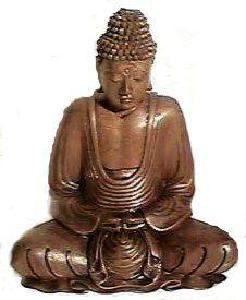

In [10]:
Image.open( './images/746f8e0c-f018-4f20-924f-61ebfba23147.jpg' )


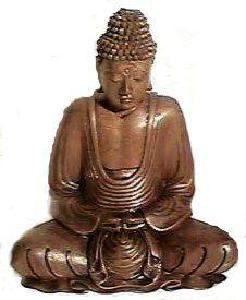

In [11]:
Image.open( './images/af00a085-66fc-4ab1-8715-e5b2fc1b7777.jpg' )

## 90% Similarity
Open files that are marked with 90% similarity above

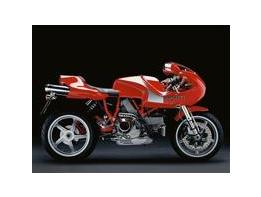

In [8]:
Image.open( './images/728db84f-fe1e-41a0-b04c-f628109224eb.jpg' )

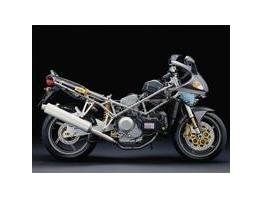

In [9]:
Image.open( './images/e0435717-b15b-4e06-ba07-6a65fe11c98d.jpg' )
